# Preprocess
Preparing proper and ready-to-use train-validate-test datasets for modelling.
<br>You can see summary of the process in the cell output along with time taken.

In [1]:
import time
preprocess_start_time = time.time()
import os
import pandas as pd
INPUT_DIR = os.path.join(os.path.dirname(os.getcwd()), 'input', 'celeba-subset')
TXT = 'list_attribute.txt'
INPUT_IMAGES_DIR = os.path.join(INPUT_DIR, 'Images')
INPUT_IMAGES_LIST = os.listdir(INPUT_IMAGES_DIR)


print("\nCopying image files to ./images, please wait...")
start_time = time.time()
import shutil
IMAGES_DIR = os.path.join(os.getcwd(), 'images')
try:
    shutil.rmtree(IMAGES_DIR)
    os.rmdir(IMAGES_DIR)
    print(f"'{IMAGES_DIR}' is found. Deleted successfully.")
    os.makedirs(IMAGES_DIR, exist_ok=True)
    print(f"'{IMAGES_DIR}' is created")
except FileNotFoundError:
    pass
shutil.copytree(INPUT_IMAGES_DIR, IMAGES_DIR, dirs_exist_ok=True)
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print("\nFinding and removing duplicates, please wait...")
start_time = time.time()
from PIL import Image
import imagehash
def remove_duplicate_images(directory):
    image_hash_map = {}
    removed_files = [] 
    for filename in os.listdir(directory):
        if not filename.endswith(('.png', '.jpg', '.jpeg')):
            continue
        if "(1)" in filename:
            os.remove(os.path.join(directory, filename))
            removed_files.append(filename)  
            continue
        with open(os.path.join(directory, filename), 'rb') as f:
            img = Image.open(f)
            img_hash = imagehash.average_hash(img)
        if img_hash in image_hash_map:
            os.remove(os.path.join(directory, filename))
            removed_files.append(filename) 
        else:
            image_hash_map[img_hash] = filename          
    return removed_files 

removed_files = remove_duplicate_images(IMAGES_DIR)
for filename in removed_files:
    print("Removed:", filename)
print(f"Number of files in {IMAGES_DIR}: {len(os.listdir(IMAGES_DIR))}")
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print(f"\nConverting {TXT} to a dataframe then filter it down to the filename and male feature.")
start_time = time.time()
df_preprocess = pd.read_csv(os.path.join(INPUT_DIR, TXT), sep="\s+", index_col=0, skiprows=1)
df_preprocess = df_preprocess[['Male']]
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))

print("\nReordering dataframe columns..")
start_time = time.time()
df_preprocess.reset_index(inplace=True)          
df_preprocess = df_preprocess[['index', 'Male']] 
df_preprocess.columns = ['Filename', 'Male']     
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print("\nSyncing dataframe with files in .input/celeba-subset/Images")
start_time = time.time()
df_preprocess = df_preprocess[df_preprocess['Filename'].isin(os.listdir(IMAGES_DIR))] 
if len(df_preprocess) == len(os.listdir(IMAGES_DIR)):
    match_str = " (MATCH)"
else:
    match_str = ""
print(f"Number of rows in dataframe: {len(df_preprocess)}{match_str}")
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print("\nEncoding the -1 in Male to 0 to facilitate the use of Binary Crossentropy Loss later.")
start_time = time.time()
df_preprocess.loc[ df_preprocess['Male'] == -1, ['Male'] ] = 0
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print("\nReset dataframe index & reorder columns")
start_time = time.time()
df_preprocess.reset_index(inplace=True)
df_preprocess = df_preprocess[['Filename', 'Male']]
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print("\nTrain : Validate : Test = 70 : 20 : 10")
print("Moving files from ./images to ./train/male ./train/female ./val/male ./val/female ./test/male ./test/female")
print("Please wait..")
from functools import partial
from typing import Tuple
from sklearn.model_selection import train_test_split 

def create_directory(directory: str) -> None:
    os.makedirs(directory, exist_ok=True)

def create_train_test_val_dirs() -> Tuple[str, str, str, str, str, str]:
    train_dir_female = os.path.join(os.getcwd(), 'train', 'female')
    train_dir_male = os.path.join(os.getcwd(), 'train', 'male')
    test_dir_female = os.path.join(os.getcwd(), 'test', 'female')
    test_dir_male = os.path.join(os.getcwd(), 'test', 'male')
    val_dir_female = os.path.join(os.getcwd(), 'val', 'female')
    val_dir_male = os.path.join(os.getcwd(), 'val', 'male')
    for directory in [train_dir_female, train_dir_male, test_dir_female, test_dir_male, val_dir_female, val_dir_male]:
        create_directory(directory)
    return train_dir_female, train_dir_male, test_dir_female, test_dir_male, val_dir_female, val_dir_male

df_train, df_validate_test = train_test_split(df_preprocess, test_size=0.3, random_state=42, stratify=df_preprocess['Male'])
df_val, df_test = train_test_split(df_validate_test, test_size=1/3, random_state=42, stratify=df_validate_test['Male'])
train_dir_female, train_dir_male, test_dir_female, test_dir_male, val_dir_female, val_dir_male = create_train_test_val_dirs()
combined_df = pd.concat([df_train, df_val, df_test])

for index, row in combined_df.iterrows():
    filename, male_value = row[['Filename', 'Male']]
    source_file = os.path.join(IMAGES_DIR, filename)
    if male_value == 1:
        dest_dir = train_dir_male if index in df_train.index else (val_dir_male if index in df_val.index else test_dir_male)
    else:
        dest_dir = train_dir_female if index in df_train.index else (val_dir_female if index in df_val.index else test_dir_female)
    shutil.move(source_file, os.path.join(dest_dir, filename))

inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))

print("\nRemoving images directory after processing, please wait...")
shutil.rmtree(IMAGES_DIR)
# os.rmdir(IMAGES_DIR)
inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))


print("\nYour dataset is ready, here\'s the breakdown:")
train_male_count = len(os.listdir(train_dir_male))
train_female_count = len(os.listdir(train_dir_female))
val_male_count = len(os.listdir(val_dir_male))
val_female_count = len(os.listdir(val_dir_female))
test_male_count = len(os.listdir(test_dir_male))
test_female_count = len(os.listdir(test_dir_female))
train_val_test_count = train_male_count+train_female_count+val_male_count+val_female_count+test_male_count+test_female_count

print(f"{train_dir_male}   : {train_male_count} images ({round(train_male_count/train_val_test_count*100)}%)")
print(f"{train_dir_female} : {train_female_count} images ({round(train_female_count/train_val_test_count*100)}%)")
print(f"{val_dir_male}     : {val_male_count}  images ({round(val_male_count/train_val_test_count*100)}%)")
print(f"{val_dir_female}   : {val_female_count}  images ({round(val_female_count/train_val_test_count*100)}%)")
print(f"{test_dir_male}    : {test_male_count}  images ({round(test_male_count/train_val_test_count*100)}%)")
print(f"{test_dir_female}  : {test_female_count}  images ({round(test_female_count/train_val_test_count*100)}%)")


preprocess_inference_time = time.time() - preprocess_start_time
print("\nPreprocess finished in total of {:.6f} seconds".format(preprocess_inference_time))


Copying image files to ./images, please wait...
Finished in 21.445713 seconds

Finding and removing duplicates, please wait...
Removed: 183111(1).jpg
Removed: 189513(1).jpg
Removed: 183121(1).jpg
Removed: 182809(1).jpg
Removed: 182793(1).jpg
Removed: 163425.jpg
Removed: 033412.jpg
Removed: 189132(1).jpg
Removed: 183005(1).jpg
Removed: 183018(1).jpg
Removed: 189324(1).jpg
Removed: 024441.jpg
Removed: 189581(1).jpg
Removed: 187343.jpg
Removed: 189512(1).jpg
Removed: 090249.jpg
Removed: 071482.jpg
Removed: 120642.jpg
Removed: 024473.jpg
Removed: 176915.jpg
Removed: 189297(1).jpg
Removed: 114141.jpg
Removed: 040124.jpg
Removed: 131144.jpg
Removed: 183050(1).jpg
Removed: 000716.jpg
Removed: 183145(1).jpg
Removed: 128266.jpg
Removed: 189651(1).jpg
Removed: 089257.jpg
Removed: 150707.jpg
Removed: 182912(1).jpg
Removed: 109263.jpg
Removed: 182943(1).jpg
Removed: 170856.jpg
Removed: 044839.jpg
Number of files in /kaggle/working/images: 4981
Finished in 4.507494 seconds

Converting list_attribu

# Modelling from a predefined popular architecture: VGG16

## Define the train, validate and test dataframes
These dataframes will be used by the ``ImageDataGenerator``


In [2]:
def create_DF(path):
    label = []
    data = []
    for fold in os.listdir(path):
        fold_path = os.path.join(path, fold)
        for file in os.listdir(fold_path):
            file_path = os.path.join(fold_path, file)
            label.append(fold)
            data.append(file_path)
    LS = pd.Series(label, name='label')
    DS = pd.Series(data, name='filepath')
    DF = pd.concat([DS, LS], axis=1)
    return DF

start_time = time.time()

train_path=os.path.join(os.getcwd(), 'train')
test_path=os.path.join(os.getcwd(), 'test')
val_path=os.path.join(os.getcwd(), 'val')

train_df=create_DF(train_path)
test_df=create_DF(test_path)
val_df=create_DF(val_path)

print(f"train_df shape: {train_df.shape}")
print(f"test_df shape: {test_df.shape}")
print(f"val_df shape: {val_df.shape}")

inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))

train_df shape: (3486, 2)
test_df shape: (499, 2)
val_df shape: (996, 2)


## Define generators for training, validating and testing
Image transformation happen here, along with training and testing batch sizes

In [3]:
start_time = time.time()

from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
img_size = (224, 224)
channels = 3 
color = 'rgb'
img_shape = (img_size[0], img_size[1], channels)

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

def scalar(img):
    return img

tr_gen = ImageDataGenerator(
    #preprocessing_function= scalar
    horizontal_flip= True 
    ,rescale=1./255  # Normalize pixel values to [0,1]
    ,rotation_range=15
    ,fill_mode='nearest'
    ,width_shift_range=0.1
    ,height_shift_range=0.1
    ,shear_range=0.2
    ,zoom_range=0.2
)
ts_gen = ImageDataGenerator(
    #preprocessing_function= scalar
    rescale=1./255
)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepath', y_col= 'label', target_size= img_size, class_mode= 'binary',
                                    color_mode= color, shuffle= True, batch_size= batch_size, seed=42)

val_gen = ts_gen.flow_from_dataframe( val_df, x_col= 'filepath', y_col= 'label', target_size= img_size, class_mode= 'binary',
                                    color_mode= color, shuffle= True, batch_size= batch_size, seed=42)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepath', y_col= 'label', target_size= img_size, class_mode= 'binary',
                                    color_mode= color, shuffle= False, batch_size= test_batch_size, seed=42)

inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))

2024-03-17 17:25:26.419783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 17:25:26.419908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 17:25:26.587582: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 3486 validated image filenames belonging to 2 classes.
Found 996 validated image filenames belonging to 2 classes.
Found 499 validated image filenames belonging to 2 classes.


## Visualize training dataset

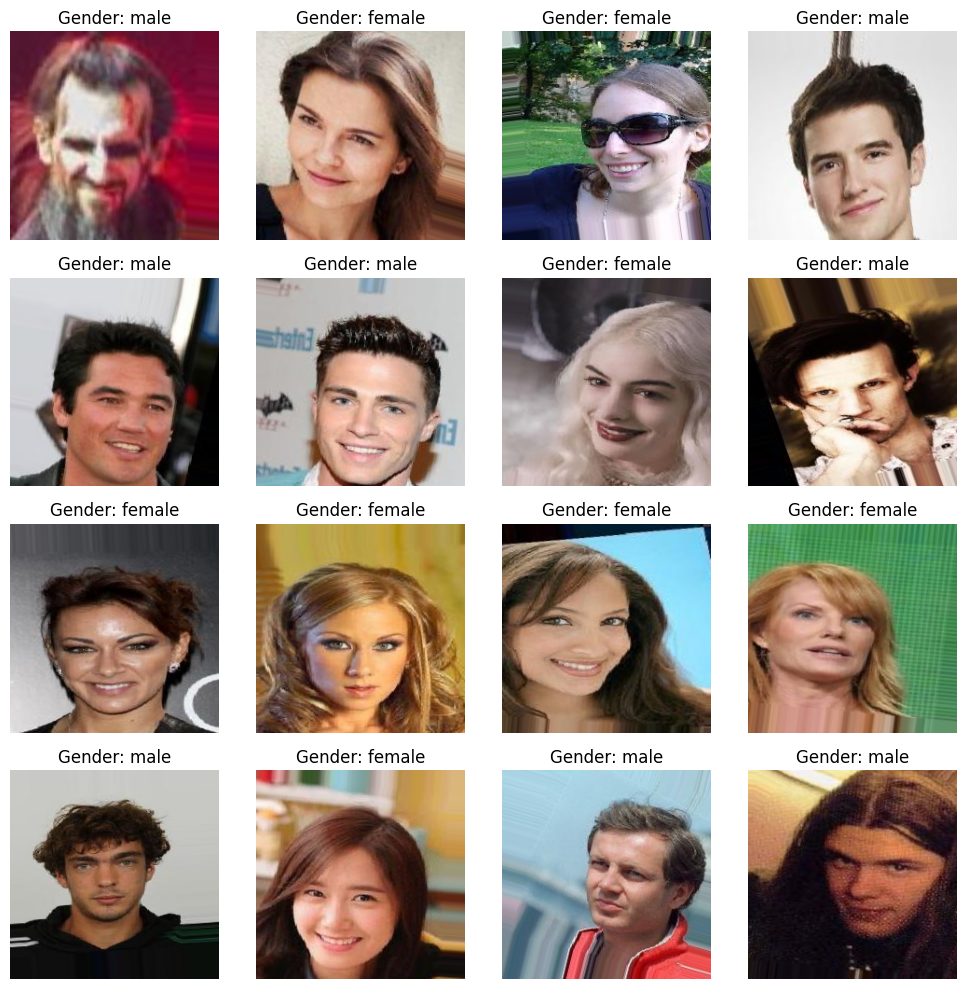

In [4]:
start_time = time.time()

import matplotlib.pyplot as plt

batch = next(train_gen)
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = i * 4 + j
        axs[i, j].imshow(batch[0][index])
        axs[i, j].axis('off')
        gender_label = "male" if batch[1][index] == 1.0 else "female"
        axs[i, j].set_title(f'Gender: {gender_label}')

plt.tight_layout()
plt.show()

inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))

## Define & Download VGG16 Model
Unfreeze functional layers before layer 15, in my experiment, this lead to a better performance

In [5]:
start_time = time.time()

from keras.applications import VGG16

TL_Models =[
    VGG16(input_shape=(img_size[0], img_size[1], 3), weights='imagenet', include_top=False)]

for tl_model in TL_Models[:15]:
    tl_model.trainable = True
    
Models_NAMES = ['VGG16']

tl_model.summary()

inference_time = time.time() - start_time
print("Finished in {:.6f} seconds".format(inference_time))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## Define Callback Functions

In [6]:
from keras.callbacks import Callback

### Callback: Dropout Scheduler
Unused because it prevent to achieve greater scores

In [7]:
class DropoutScheduler(Callback):
    def __init__(self, dropout_schedule):
        super(DropoutScheduler, self).__init__()
        self.dropout_schedule = dropout_schedule

    def on_epoch_begin(self, epoch, logs=None):
        if epoch in self.dropout_schedule:
            new_dropout_rate = self.dropout_schedule[epoch]
            for layer in self.model.layers:
                if isinstance(layer, layers.Dropout):
                    layer.rate = new_dropout_rate
            print(f"\nDropout rate set to {new_dropout_rate} for epoch {epoch+1}")

dropout_schedule = {0:0.05, 10:0.1, 20:0.15, 30:0.2, 40:0.2, 50:0.3, 60:0.35, 70:0.4, 80:0.45, 90:0.5}
dropout_scheduler = DropoutScheduler(dropout_schedule)

### Callback: Reduce Learning Rate on Plateau
Unused because it prevent to achieve greater scores

In [8]:
from keras.callbacks import ReduceLROnPlateau
RLR_MON = 'val_loss'
RLR_PAT = 5
RLR_F = 0.125
RLR_MLR = 0.00001
RLR_VRB = 1

### Callback: Early Stopping

In [9]:
from keras.callbacks import EarlyStopping
ES_MON = 'val_loss'
ES_PAT = 15
ES_VRB = 1

### Callback: L2 Regularization

In [10]:
class L2RegularizationCallback(Callback):
    def __init__(self, l2_penalty):
        super(L2RegularizationCallback, self).__init__()
        self.l2_penalty = l2_penalty

    def on_epoch_begin(self, epoch, logs=None):
        for layer in self.model.layers:
            if isinstance(layer, layers.Dense):
                layer.kernel_regularizer = regularizers.l2(self.l2_penalty)

## Train and optimize the model

In [11]:
# from keras.callbacks import LearningRateScheduler
import keras
from keras import layers
from keras.layers import GlobalMaxPooling2D #Activation, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, 
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import optimizers

L2_PENALTY = 0.0005
EPOCH_COUNT= 50
OPTIMIZER = optimizers.SGD(learning_rate=1e-4, momentum=0.9) #Adam(beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)
HEAD_DROPOUT_RATE=0.5

LOSS_F='binary_crossentropy'

training_times = []
model_histories = []

for i, tl_model in enumerate(tqdm(TL_Models, desc="Training TL Models")):
    print(f"Training Model {i}: {tl_model.name}")

#     # Set up the TL model with L2 regularization
#     for layer in tl_model.layers:
#         if isinstance(layer, layers.Dense):
#             layer.kernel_regularizer = regularizers.l2(L2_PENALTY)
            
    model = keras.Sequential([
        tl_model,
        layers.GlobalMaxPooling2D(), 
        #layers.Flatten(),
        layers.Dense(512, activation='relu'), 
        layers.Dropout(HEAD_DROPOUT_RATE),
        layers.Dense(1, activation='sigmoid')
    ])

    start_time = time.time()

    model.compile(optimizer=OPTIMIZER, loss=LOSS_F, metrics=['accuracy'])

    cbs = [
#         ReduceLROnPlateau(monitor=RLR_MON, patience=RLR_PAT, factor=RLR_F, min_lr=RLR_MLR, verbose=RLR_VRB),
        EarlyStopping(monitor=ES_MON, patience=ES_PAT, restore_best_weights=True, verbose=ES_VRB),
#         dropout_scheduler,
        ModelCheckpoint(tl_model.name + ".keras", save_best_only=True)
    ]
    
    history = model.fit(train_gen, epochs=EPOCH_COUNT, validation_data=val_gen, callbacks=[cbs])
    
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

    model_histories.append(history.history)

for i, time_taken in enumerate(training_times):
    print(f"Model {i+1}: {tl_model.name} Training time: {time_taken:.2f} seconds")

Training TL Models:   0%|          | 0/1 [00:00<?, ?it/s]

Training Model 0: vgg16
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1710696387.352653     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710696387.375665     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.6385 - loss: 0.6714

W0000 00:00:1710696472.277534     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


218/218 ━━━━━━━━━━━━━━━━━━━━ 142s 443ms/step - accuracy: 0.6389 - loss: 0.6707 - val_accuracy: 0.8946 - val_loss: 0.2566
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 52s 232ms/step - accuracy: 0.8765 - loss: 0.2964 - val_accuracy: 0.9086 - val_loss: 0.2235
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 52s 234ms/step - accuracy: 0.9072 - loss: 0.2321 - val_accuracy: 0.9267 - val_loss: 0.1843
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 52s 234ms/step - accuracy: 0.9361 - loss: 0.1662 - val_accuracy: 0.9408 - val_loss: 0.1463
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 52s 235ms/step - accuracy: 0.9428 - loss: 0.1345 - val_accuracy: 0.9428 - val_loss: 0.1331
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 52s 235ms/step - accuracy: 0.9446 - loss: 0.1363 - val_accuracy: 0.9468 - val_loss: 0.1329
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 52s 232ms/step - accuracy: 0.9648 - loss: 0.1212 - val_accuracy: 0.9347 - val_loss: 0.1586
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 52s 233ms/step - accuracy: 0.9631 - loss: 0.1048 - va

Training TL Models: 100%|██████████| 1/1 [31:00<00:00, 1860.13s/it]

Model 1: vgg16 Training time: 1860.12 seconds


## Validation accuracy & loss

/tmp/ipykernel_34/3737340533.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, i+1)  # Create subplots for each metric


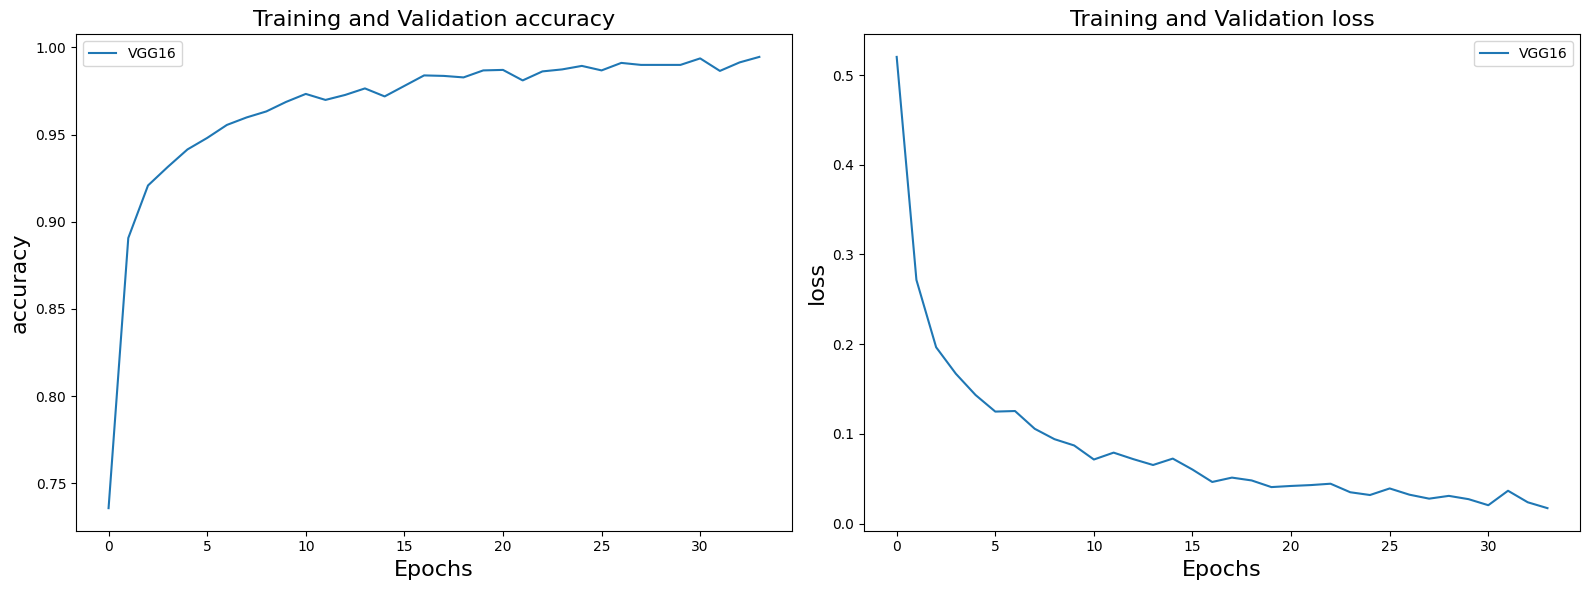

In [12]:
metrics_to_plot = ['accuracy', 'loss']

fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(16, 6))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(1, 2, i+1)  
    for idx, history in enumerate(model_histories):
        plt.plot(history[metric], label=Models_NAMES[idx])
    plt.title(f'Training and Validation {metric}', fontsize=16)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel(metric, fontsize=16)
    plt.legend()

plt.tight_layout()
plt.show()

# Test the model

In [13]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

print(f"test_df size   : {ts_length}")
print(f"Test Batch Size: {test_batch_size}")
print(f"Test Steps     : {test_steps}")

start_time = time.time()

test_score  = model.evaluate(test_gen, steps= test_steps, verbose= 0)

inference_time = time.time() - start_time
print('-' * 20)
print("\nInference Time: {:.6f} seconds".format(inference_time))

print('-' * 20)
print(f"Test Loss: {test_score [0]}")
print(f"Test Accuracy: {test_score [1]}")

test_df size   : 499
Test Batch Size: 1
Test Steps     : 499
--------------------

Inference Time: 7.768905 seconds
--------------------
Test Loss: 0.10118663311004639
Test Accuracy: 0.9639278650283813


## Classification metrics: Confussion Matrix, ROC Curve, Precision-Recall Curve

499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


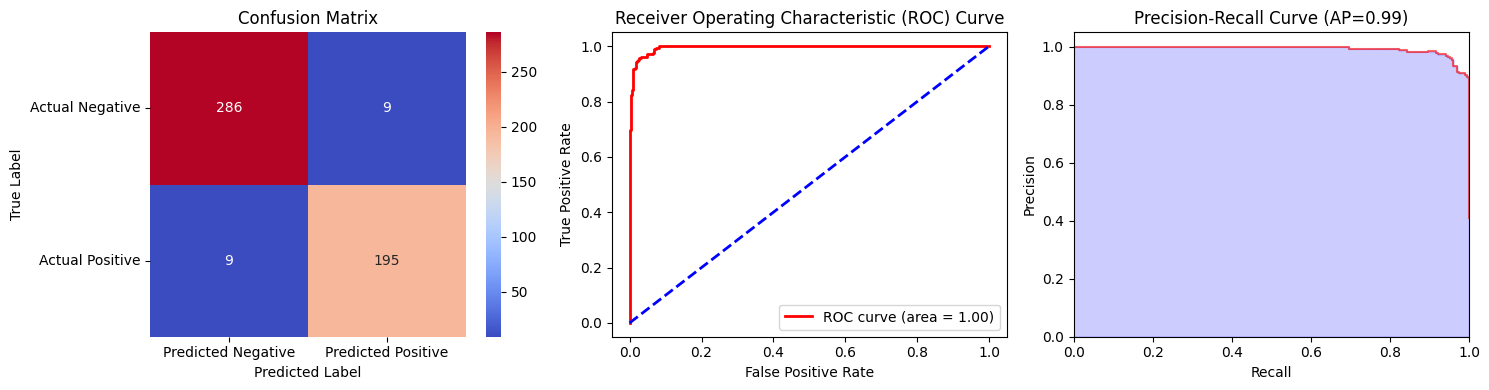

In [14]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns

# Confusion Matrix
true_labels = test_gen.classes
predictions = model.predict(test_gen)
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

plt.figure(figsize=(15, 4))

# Plot Confusion Matrix
plt.subplot(1, 3, 1)
conf_matrix = confusion_matrix(true_labels, binary_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='coolwarm', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks(rotation=0)

# Plot ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Plot Precision-Recall Curve
plt.subplot(1, 3, 3)
precision, recall, _ = precision_recall_curve(true_labels, predictions)
average_precision = average_precision_score(true_labels, predictions)
plt.step(recall, precision, color='r', alpha=0.6, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AP={0:.2f})'.format(average_precision))

plt.tight_layout()
plt.show()

## Confusion Matrix scores, ravelled

In [15]:
tn, fp, fn, tp = conf_matrix.ravel()
accuracy = round((tp + tn) / (tp + tn + fp + fn) * 100, 2)
precision = round(tp / (tp + fp) * 100, 2) if (tp + fp) != 0 else 0
recall = round(tp / (tp + fn) * 100, 2) if (tp + fn) != 0 else 0
f1_score = round(2 * (precision * recall) / (precision + recall), 2) if (precision + recall) != 0 else 0

print(f"\nTrue Positive  = {tp}")
print(f"False Positive = {fp}")
print(f"True Negative  = {tn}")
print(f"False Negative = {fn}")
print('\nAccuracy  = {:.4f}'.format(accuracy))
print('Precision = {:.4f}'.format(precision))
print('Recall    = {:.4f}'.format(recall))
print('F1 Score  = {:.4f}'.format(f1_score))


True Positive  = 195
False Positive = 9
True Negative  = 286
False Negative = 9

Accuracy  = 96.3900
Precision = 95.5900
Recall    = 95.5900
F1 Score  = 95.5900


## Predict faces from internet

In [16]:
INET_IMG_DIR = os.path.join(os.getcwd(), 'internet_img/')

try:
    shutil.rmtree(INET_IMG_DIR)
    print(f"Directory '{INET_IMG_DIR}' deleted successfully.")
except FileNotFoundError:
    pass

os.makedirs(INET_IMG_DIR, exist_ok=True)

In [17]:
import requests
import re

def download_image_with_number(url, save_path, gender):
  basename = os.path.splitext(os.path.basename(save_path))[0]

  highest_number = 0
  for filename in os.listdir(save_path):
    match = re.search(rf"{gender}_(\d+)", filename)
    if match:
      highest_number = max(highest_number, int(match.group(1)))

  new_number = str(highest_number + 1).zfill(3)  
  filename = f"{save_path}{gender}_{new_number}.jpg"  

  try:
    response = requests.get(url, stream=True)
    response.raise_for_status()

    with open(filename, 'wb') as f:
      for chunk in response.iter_content(1024):
        f.write(chunk)

    print(f"Image downloaded successfully from {url} and saved to {filename}")
  except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")

In [18]:
image_url = "https://3.bp.blogspot.com/-lHgAnrx9xFU/WYcOdaftv4I/AAAAAAAAAtY/32vSoUSst1cadnet_Cwm1K69bVCIfmbnwCLcBGAs/s1600/Foto%2BIr%2BSukarno.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

image_url = "https://1.bp.blogspot.com/-qTcfI6Hs8Gg/TiA4zgjSKkI/AAAAAAAAAHs/R2sWS_KcCSg/w1200-h630-p-k-no-nu/soeharto%252C.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

image_url = "https://www.thoughtco.com/thmb/h1reaISnCmBBOgqh8dxAjgJb3JA=/3000x1941/filters:no_upscale():max_bytes(150000):strip_icc()/MegawatibyDimasArdianGetty2004-56a041d63df78cafdaa0b54b.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "female")

image_url = "https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEj7r6CXQ-zB3SRF-qdCCyOBBwtPm_1mU6oL7JQGr8TQjyww41jBp7QE096yQl6sc-ZpPDCQwosIw7vS2gOEjGHOHZPME8Tpnf0fu5qeQGkRM6DzbzOzyALIM5Np756BWBGVhawmrRokKoRQRtJmz2zu2oYE62glkaNe2KAcRy6V1I5WmUm4yYuzZyjSeg/s1136/Biografi%20Bu%20Puan%20Maharani,%20Putri%20Bu%20Megawati%20Soekarnoputri%20dan%20Cucu%20Bung%20Karno%20Sang%20Proklamator.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "female")

image_url = "https://thumbs.dreamstime.com/b/handsome-latino-man-20185194.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

image_url = "https://i.pinimg.com/736x/ac/68/7c/ac687c962a1c40f23360c45b20c4d31a--beauty-queens-universe.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "female")

image_url = "https://i.pinimg.com/originals/9f/a3/e4/9fa3e48c7f9696ee4bf337af74136a28.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

image_url = "https://www.ursulasweeklywanders.com/wp-content/uploads/2020/02/08-22825-post/000003-Enga-Woman_1803.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "female")

image_url = "https://allthatsinteresting.com/wordpress/wp-content/uploads/2014/05/old-eskimo.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

image_url = "https://live.staticflickr.com/4105/4951753576_91e36b48cc_o.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "female")

image_url = "https://images.saymedia-content.com/.image/t_share/MTc0NDg2ODMwMjY2MTk3MzUy/top-10-kpop-male-solo-artists.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

image_url = "https://i.pinimg.com/originals/90/39/a7/9039a708273088667c4562cab89c39e6.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "female")

image_url = "https://1.bp.blogspot.com/-rUOpHKW7HiU/Xyu01mP955I/AAAAAAAA_CM/HDly5twbSpcu_YiabKguiz4QZqT5UEnnQCLcBGAsYHQ/s500/75a655086de9e657eeb1699ed4fccbf2.jpg"
download_image_with_number(image_url, INET_IMG_DIR, "male")

Image downloaded successfully from https://3.bp.blogspot.com/-lHgAnrx9xFU/WYcOdaftv4I/AAAAAAAAAtY/32vSoUSst1cadnet_Cwm1K69bVCIfmbnwCLcBGAs/s1600/Foto%2BIr%2BSukarno.jpg and saved to /kaggle/working/internet_img/male_001.jpg
Image downloaded successfully from https://1.bp.blogspot.com/-qTcfI6Hs8Gg/TiA4zgjSKkI/AAAAAAAAAHs/R2sWS_KcCSg/w1200-h630-p-k-no-nu/soeharto%252C.jpg and saved to /kaggle/working/internet_img/male_002.jpg
Image downloaded successfully from https://www.thoughtco.com/thmb/h1reaISnCmBBOgqh8dxAjgJb3JA=/3000x1941/filters:no_upscale():max_bytes(150000):strip_icc()/MegawatibyDimasArdianGetty2004-56a041d63df78cafdaa0b54b.jpg and saved to /kaggle/working/internet_img/female_001.jpg
Image downloaded successfully from https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEj7r6CXQ-zB3SRF-qdCCyOBBwtPm_1mU6oL7JQGr8TQjyww41jBp7QE096yQl6sc-ZpPDCQwosIw7vS2gOEjGHOHZPME8Tpnf0fu5qeQGkRM6DzbzOzyALIM5Np756BWBGVhawmrRokKoRQRtJmz2zu2oYE62glkaNe2KAcRy6V1I5WmUm4yYuzZyjSeg/s1136/Biografi%2

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Prediction [[0.9823843]]


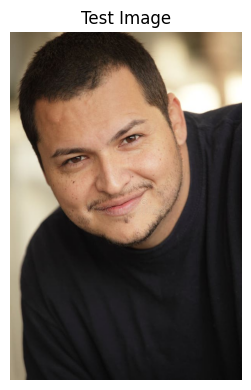

Image: /kaggle/working/internet_img/male_003.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction [[0.66818494]]


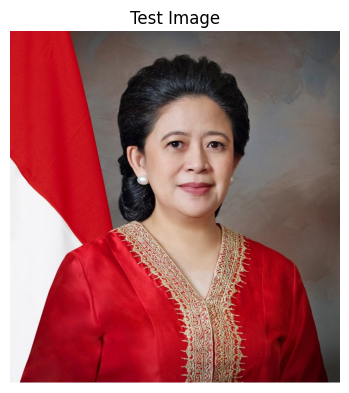

Image: /kaggle/working/internet_img/female_002.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction [[0.27632058]]


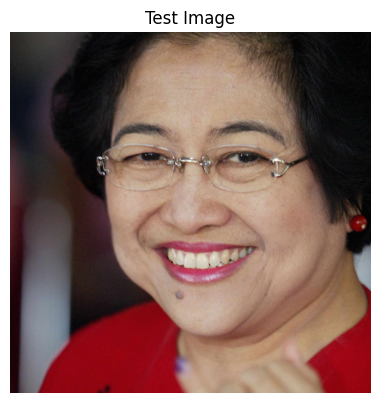

Image: /kaggle/working/internet_img/female_001.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction [[0.9997477]]


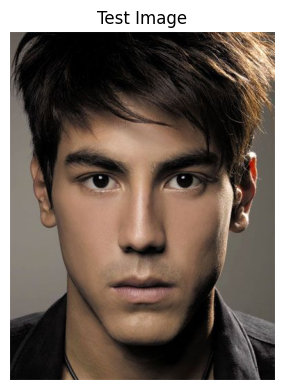

Image: /kaggle/working/internet_img/male_007.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction [[0.97046185]]


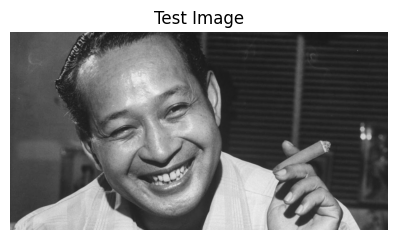

Image: /kaggle/working/internet_img/male_002.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction [[0.9955219]]


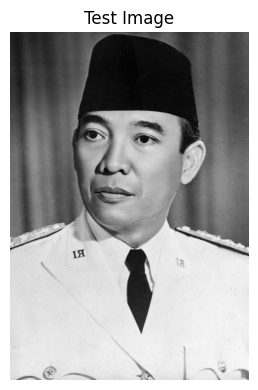

Image: /kaggle/working/internet_img/male_001.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction [[0.08657541]]


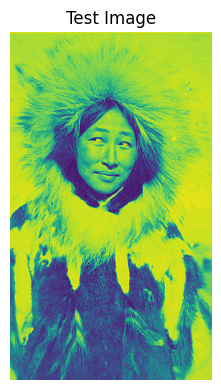

Image: /kaggle/working/internet_img/female_004.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction [[7.1083673e-06]]


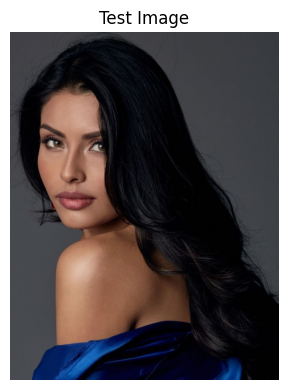

Image: /kaggle/working/internet_img/female_003.jpg
Model predicts: Female
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction [[0.8431016]]


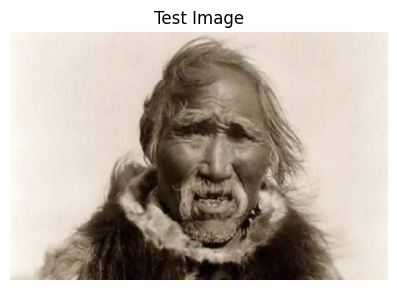

Image: /kaggle/working/internet_img/male_005.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction [[0.9911777]]


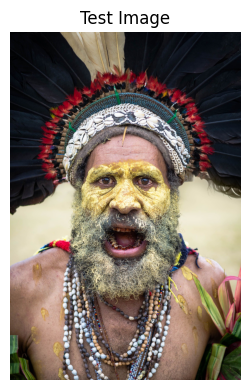

Image: /kaggle/working/internet_img/male_004.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction [[0.79941726]]


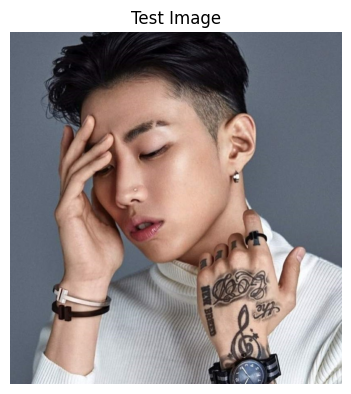

Image: /kaggle/working/internet_img/male_006.jpg
Model predicts: Male
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction [[2.6095304e-05]]


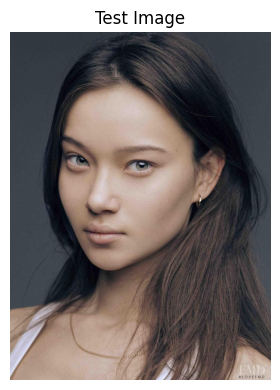

Image: /kaggle/working/internet_img/female_005.jpg
Model predicts: Female
------------------------------


In [19]:
from glob import glob
from tensorflow.keras.preprocessing import image
import numpy as np
from keras.applications.mobilenet_v2 import preprocess_input

image_paths = glob(f"{INET_IMG_DIR}*.jpg")  

for image_path in image_paths:
  img = image.load_img(image_path, target_size=img_size)
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = preprocess_input(img_array)

  prediction = model.predict(img_array)

  print(f"Prediction {prediction}")

  female_prob = round(1 - prediction[0][0] * 100, 2)
  male_prob = round(prediction[0][0] * 100, 2)

  if male_prob > female_prob:
    result = "Male"
  else:
    result = "Female"

  plt.figure(figsize=(8, 4))

  plt.subplot(1, 2, 1)
  img = Image.open(image_path)
  plt.imshow(img)
  plt.axis('off')
  plt.title('Test Image')

  plt.tight_layout()
  plt.show()

  print(f"Image: {image_path}")
  print(f"Model predicts: {result}")
  print("-" * 30)  